# Xarray

Xarray is like a multi-dimensional version of pandas.

Xarray is also built for handling netcdf files.

Dask is an optional dependancy for xarray.  This allows you to work with model outputs that are bigger than memory in parallel.

In [15]:
!curl -L -o newName.zip  https://www.dropbox.com/sh/3joh2zdxgqvblhc/moc_transports.nc?dl=1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  749k  100  749k    0     0   444k      0  0:00:01  0:00:01 --:--:-- 3845k


In [28]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import lplots.anim as anim

%matplotlib inline

In [35]:
lon = np.linspace(0,360,360)
lat = np.linspace(-90,90,180)
Lon, Lat = np.meshgrid(lon, lat)
months = np.arange(24)
temp = 15 + 10*np.cos(2*np.pi*Lat/360)
temp = np.transpose( np.tile(temp,(len(months),1,1)), (2,1,0) )
for mon in months:
    temp[:,:,mon] = temp[:,:,mon] -5*np.sin(2 * np.pi * mon/12)*np.sin(2*np.pi*Lat.T/360)
    #plt.pcolormesh(Lon.T, Lat.T, temp[:,:,mon],vmin = 10, vmax = 26)
    #plt.show()

In [40]:
ds = xr.DataArray(temp, coords=[lon,lat, months], dims = ['lon','lat','time'])
ds.to_netcdf('temp_array')

In [41]:
ds = xr.open_dataset('temp_array')

- The labelling means that we don't have to remember in which order x/y/z/t are stored.

In [53]:
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns # pandas aware plotting library

np.random.seed(123)

times = pd.date_range('2000-01-01', '2001-12-31', name='time',freq='M')
annual_cycle = np.sin(2 * np.pi * (times.dayofyear.values / 365.25 - 0.28))

lon = np.linspace(0,360,360)
lat = np.linspace(-90,90,180)
Lon, Lat = np.meshgrid(lon, lat)
months = np.arange(24)
temp = 15 + 10*np.cos(2*np.pi*Lat/360)

temp = np.transpose( np.tile(temp,(len(months),1,1)), (1,2,0) )
for idx,mon in enumerate( times ):
    temp[:,:,idx] = temp[:,:,idx] -5*annual_cycle[idx]*np.sin(2*np.pi*Lat/360)*np.sin(2*np.pi*Lon/360)

ds = xr.Dataset({'temperature': (('lat', 'lon', 'time'), temp)},
                {'time': times, 'lon': lon, 'lat':lat})

In [51]:
ds

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360, time: 24)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-31 2000-02-29 2000-03-31 ...
  * lon          (lon) float64 0.0 1.003 2.006 3.008 4.011 5.014 6.017 7.019 ...
  * lat          (lat) float64 -90.0 -88.99 -87.99 -86.98 -85.98 -84.97 ...
Data variables:
    temperature  (lat, lon, time) float64 10.29 11.68 14.04 16.58 18.77 19.9 ...

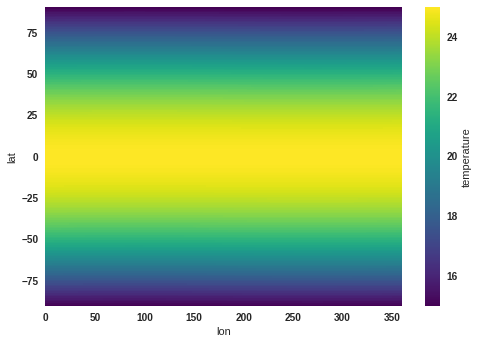

In [55]:
ds.temperature.mean(dim = 'time').plot()
plt.show()